In [30]:
import meep as mp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
print(mp.__version__)
from scipy import signal
from time import sleep
import sys
from numpy.fft import fft, ifft, fftfreq

1.23.0


[Finite-difference time-domain simulation of thermal noise in open cavities](https://doi.org/10.1103/PhysRevA.77.023810)
$$D_n (\omega,T) = \frac{6\hbar^2}{\pi k_B^2 T^2}\left(\frac{\omega}{\exp\frac{\hbar\omega}{k_B T}-1}\right)$$

When $\omega = 0$, the denominator is zero, which causes the numerical problem. The remedy is to use Taylor expansion as $x\ll 1$.

$$\frac{1}{\exp{x}-1} = 1 - \frac{x}{2} + \frac{x^2}{12}-\frac{x^4}{720}+O(x^6)$$


/tmp/ipykernel_183/1942646252.py:5: RuntimeWarning: invalid value encountered in true_divide
  f1 = x /tmp ## there is a warning since tmp[0] = 0


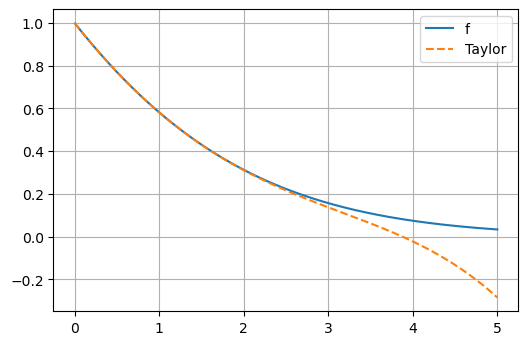

In [31]:
## Test the equation
Nx = 1000
x = np.linspace(0,5,Nx)
tmp = np.exp(x) -1
f1 = x /tmp ## there is a warning since tmp[0] = 0
f2 = 1 - x/2 + x **2/12 -x**4/720
##
fig = plt.figure(dpi=100)
plt.plot(x,f1,label='f')
plt.plot(x,f2,'--',label='Taylor')
plt.grid()
plt.legend()
plt.show()
                

In [36]:
##

resolution = 100                # pixels/um
dpml = 1.0                      # PML thickness
sz = 16 + 2*dpml
cell_size = mp.Vector3(z=sz)
pml_layers = [mp.PML(dpml)]

dimensions = 1
tsim = 10000
courant = 1 
dt = courant  / resolution
Nt = int(tsim/dt + 1)
tslice = np.linspace(0, tsim, Nt)

##
omegal = 2 * np.pi / Nt * np.linspace(0,Nt-1,Nt) 
ml = np.random.normal(0,1,Nt)
nl = np.random.normal(0,1,Nt)

We adopt Eq. (6) from [PHYSICAL REVIEW A 77, 023810 (2008)](https://doi.org/10.1103/PhysRevA.77.023810), but make some changes of the definitions. 
$$E_s(t) = \frac{\delta}{\sqrt{t_\mathrm{sim}}}\sum_{l=0}^{N_t-1} (M_l + i N_l)D_n(\omega_l,T)e^{i\omega_l t}$$

In [37]:
#setup some constants and parameters
M=2**21 #模擬步數
tsim=7e-12 #模擬長度
eps0 = 8.854187e-12 
hbar = 1.05457182e-34
c = 2.99792458e8
kb = 1.380649e-23
hdk=7.63823258e-12 # hbar/kb
T=30000
deltap = np.sqrt(1/3/eps0/hbar/c)*kb*T #小delta
frequency = np.linspace(0, 25, 2*M)*10**15
omega = frequency*2*np.pi

In [40]:
##

def Dnsqr(omega,T):
    x = np.abs(omega/T)
    if x > 1e-3:
        
        output = np.sqrt(6*hdk**2*omega/(np.exp(hdk*omega/T)-1)/T**2/np.pi)
    else:
        output = np.sqrt(6*hdk/np.pi/T) ## Taylor expansion
    
    output = np.sqrt(output)
    return output

tempe = 1
dlsqr = np.empty(Nt)

for i in range(Nt):
     dlsqr[i] = Dnsqr(omegal[i],tempe) 


        ## Fourier component from Eq. 6        
    
## use fft to generate signal
ts1 = time.time()

  

Ef = ifft(fc)

te1 = time.time()
Efsum = np.zeros(Nt)
Ncomp = 50
for i in range(Ncomp):
     
    ml = np.random.normal(0,1,Nt)
    nl = np.random.normal(0,1,Nt)
    fc = (ml + 1j * nl) * dlsqr
    Ef = ifft(fc)
    Eautoc = signal.correlate(Ef,Ef)
    Eautocf = np.fft.fft(Eautoc[len(Ef)-1:])
    Eautocf = np.real(Eautocf)
    Efsum += Eautocf
    
    #generate some feedback to check the progress of the loop
    x = i/Ncomp*100
    sys.stdout.write('\r')
    sys.stdout.write("[%-20s] %d%%" % ('m'*int(x), int(x)))
    sys.stdout.flush()
    sleep(0.0001)

#average the final result
Efavg = Efsum/Ncomp
## use for loop to generate signal

#Ef2 =np.empty(Nt) 

#ts2 = time.time()

#Ef2 = np.zeros(Nt,dtype=complex)

#for i in range(Nt):
       #Ef2[i] = sum( fc * np.exp(1j * omegal * i))/Nt

#te2 = time.time()

[mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm] 98%

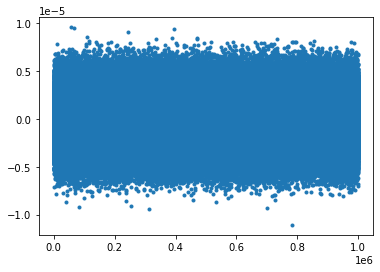

In [43]:
plt.plot(Ef,'.')